
 # Phase 1: Analytics
 ## Introduction

 Perform exploratory data analysis (EDA) on the Lending Club dataset. Objectives include defining a target variable for credit risk, analysing feature relationships with the target, assessing historical portfolio trends, and identifying preprocessing needs for modelling.


 ### 1. Setup and Imports

In [ ]:
# %%

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from pathlib import Path

# Configure settings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


 ### 2. Data Loading and Initial Checks

In [ ]:
# Define data path (assuming 'data' folder is in the same directory as the script)
from pathlib import Path

data_dir = Path('./data')
DATA_DIR = str(data_dir)

if not data_dir.is_dir():
    print(f"Warning: Data directory not found at expected location: {data_dir.resolve()}")
else:
    print(f"Data directory set to: {DATA_DIR}")

Data directory set to: c:\Users\avka\OneDrive\Documents\Coding_Projects\plata\data


In [ ]:
# %%

# Load the accepted loans data
accepted_file = os.path.join(DATA_DIR, 'accepted_2007_to_2018Q4.csv')

df = None
try:
    # Use low_memory=False due to mixed dtypes
    df = pd.read_csv(accepted_file, low_memory=False)
    print(f"Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {accepted_file}.")
except Exception as e:
    print(f"An error occurred during data loading: {e}")

Data loaded successfully. Shape: (2260701, 151)



 #### 2.1 Initial Data Overview

In [ ]:
# %%

# Display basic information
if df is not None:
    print("\n--- First 5 Rows ---")
    print(df.head())

    print("\n--- DataFrame Info --- ")
    df.info(verbose=True, show_counts=True)
else:
    print("\nDataFrame not loaded.")


--- First 5 Rows ---
         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade                    emp_title  \
0     13.99       123.03     C        C4                      leadman   
1     11.99       820.28     C        C1                     Engineer   
2     10.78       432.66     B        B4                 truck driver   
3     14.85       829.90     C        C5  Information Systems Officer   
4     22.45       289.91     F        F1          Contract Specialist   

  emp_length home_ownership  annual_inc verification_status   is


 **Findings:**
 *   **Head:** Shows mix of numerical, categorical, date-like object columns, identifiers, and free text.
 *   **Info:** Confirms 151 columns. Reveals significant variation in non-null counts, indicating widespread missing data, particularly in `sec_app_*`, `*_joint`, `hardship_*`, `settlement_*` columns. Memory usage > 2.5 GB.


 ### 3. Basic Cleaning and Preprocessing


 #### 3.1 Date Parsing

In [ ]:
# %%

# Identify and Parse Date Columns
if df is not None:
    date_cols = [
        'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d',
        'last_credit_pull_d', 'sec_app_earliest_cr_line'
    ]
    parsed_cols, failed_cols, not_found_cols = [], [], []

    for col in date_cols:
        if col in df.columns:
            try:
                df[col] = pd.to_datetime(df[col], errors='coerce') # Coerce errors to NaT
                parsed_cols.append(col)
            except Exception as e:
                # Log or handle specific parsing errors if needed
                failed_cols.append(col)
        else:
            not_found_cols.append(col)

    print(f"Date columns parsed: {len(parsed_cols)}")
    if not_found_cols: print(f"Date columns not found: {not_found_cols}")
    if failed_cols: print(f"Date columns failed to parse: {failed_cols}")
else:
    print("\nDataFrame not loaded. Skipping date parsing.")

Date columns parsed: 6



 Key date columns converted to datetime objects.



 #### 3.2 Define Target Variable ("Bad" Loan Status)

In [ ]:
# %%

# Analyse 'loan_status' distribution
if df is not None:
    print("\n--- 'loan_status' Distribution (Raw Data) ---")
    status_counts = df['loan_status'].value_counts(normalize=False)
    status_percent = df['loan_status'].value_counts(normalize=True) * 100
    status_df = pd.DataFrame({'Count': status_counts, 'Percentage (%)': status_percent.round(2)})
    print(status_df)
else:
    print("\nDataFrame not loaded.")


--- 'loan_status' Distribution (Raw Data) ---
                                                      Count  Percentage (%)
loan_status                                                                
Fully Paid                                          1076751           47.63
Current                                              878317           38.85
Charged Off                                          268559           11.88
Late (31-120 days)                                    21467            0.95
In Grace Period                                        8436            0.37
Late (16-30 days)                                      4349            0.19
Does not meet the credit policy. Status:Fully Paid     1988            0.09
Does not meet the credit policy. Status:Charged...      761            0.03
Default                                                  40            0.00


`loan_status` distribution shows 'Fully Paid' and 'Current' dominate (>86%). 'Charged Off' is ~12%. Ongoing statuses need filtering for default/charge-off prediction.


 ##### Filtering for Definitive Outcomes

In [ ]:
# %%

# Define target variable `is_bad` and filter data
if df is not None:
    bad_indicators = [
        'Charged Off',
        'Default',
        'Does not meet the credit policy. Status:Charged Off',
    ]
    good_indicators = ['Fully Paid']

    def map_loan_status(status):
        if status in bad_indicators: return 1
        elif status in good_indicators: return 0
        else: return -1 # Mark for filtering

    df['is_bad'] = df['loan_status'].apply(map_loan_status)

    original_rows = df.shape[0]
    df_filtered = df[df['is_bad'] != -1].copy()
    filtered_rows = df_filtered.shape[0]

    print(f"\nFiltered DataFrame from {original_rows} to {filtered_rows} rows (Good/Bad outcomes only).")
    print("Value counts for 'is_bad' in filtered data:")
    print(df_filtered['is_bad'].value_counts(normalize=True).round(4) * 100)
    print(df_filtered['is_bad'].value_counts(normalize=False))

    # Update main df variable
    df = df_filtered


Filtered DataFrame from 2260701 to 1346111 rows (Good/Bad outcomes only).
Value counts for 'is_bad' in filtered data:
is_bad
0    79.99
1    20.01
Name: proportion, dtype: float64
is_bad
0    1076751
1     269360
Name: count, dtype: int64



 **Findings:**
 *   "Bad" loans defined as 'Charged Off' or 'Default'. "Good" loans defined as 'Fully Paid'.
 *   Binary target `is_bad` created.
 *   DataFrame filtered to retain only loans with definitive outcomes.
 *   *Note: Bad rate requires re-calculation after running this cell.* Class imbalance needs consideration in modelling.


 #### 3.3 Missing Value Assessment (Post-Filtering)

In [ ]:
# %%

# Re-assess Missing Values
if df is not None:
    print("\n--- Missing Values Assessment (Post-Filtering) ---")
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing Percent (%)': missing_percent})
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Percent (%)', ascending=False)

    print("Columns with missing values:")
    if not missing_df.empty:
        with pd.option_context('display.max_rows', None): print(missing_df)
    else:
        print("No missing values found.")

    # Drop columns with > threshold% missing
    threshold = 40
    cols_to_drop = missing_df[missing_df['Missing Percent (%)'] > threshold].index.tolist()

    if cols_to_drop:
        print(f"\nDropping {len(cols_to_drop)} columns with > {threshold}% missing values.")
        df.drop(columns=cols_to_drop, inplace=True)
        print(f"New DataFrame shape: {df.shape}")
    else:
        print(f"\nNo columns found with more than {threshold}% missing values.")
else:
     print("\nDataFrame not available.")


--- Missing Values Assessment (Post-Filtering) ---
Columns with missing values:
                                            Missing Count  Missing Percent (%)
member_id                                         1346111           100.000000
next_pymnt_d                                      1345310            99.940495
orig_projected_additional_accrued_interest        1342350            99.720603
hardship_loan_status                              1340355            99.572398
hardship_start_date                               1340355            99.572398
hardship_end_date                                 1340355            99.572398
hardship_status                                   1340355            99.572398
hardship_type                                     1340355            99.572398
hardship_amount                                   1340355            99.572398
hardship_dpd                                      1340355            99.572398
hardship_length                                   


 **Findings:**
 *   Missing value percentages recalculated.
 *   Columns exceeding 40% missingness threshold dropped (58 columns).
 *   Remaining columns (e.g., `mths_since_recent_inq`, `emp_length`) still require imputation.
 *   DataFrame `df` now has 94 columns.


 ### 4. Feature Analysis & Selection for EDA


 #### 4.1 Initial Feature Separation

In [ ]:
# %%

# Identify numerical and categorical features
if df is not None:
    potential_features = df.drop(columns=['is_bad', 'loan_status'], errors='ignore').columns
    numerical_cols = df[potential_features].select_dtypes(include=np.number).columns.tolist()
    categorical_cols = df[potential_features].select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"\nIdentified {len(numerical_cols)} numerical and {len(categorical_cols)} categorical features.")
else:
    print("\nDataFrame not available.")
    numerical_cols, categorical_cols = [], []


Identified 69 numerical and 19 categorical features.



 #### 4.1.1 Numerical Feature Statistics (Skewness & Kurtosis)

In [ ]:
# %%

# Calculate skewness and kurtosis
if df is not None and numerical_cols:
    stats_df = pd.DataFrame({
        'Skewness': df[numerical_cols].skew(),
        'Kurtosis': df[numerical_cols].kurt()
    }).sort_values(by='Skewness', key=abs, ascending=False)

    print("\n--- Skewness and Kurtosis --- ")
    with pd.option_context('display.max_rows', 100): print(stats_df)

    # Identify highly skewed features
    skew_threshold = 1.0
    highly_skewed = stats_df[abs(stats_df['Skewness']) > skew_threshold].index.tolist()
    print(f"\nFeatures with absolute skewness > {skew_threshold}: {len(highly_skewed)}")
else:
    print("\nDataFrame or numerical columns not available.")


--- Skewness and Kurtosis --- 
                              Skewness       Kurtosis
tot_coll_amt                666.323050  484000.760458
out_prncp_inv               300.148377   99438.029514
out_prncp                   300.148377   99438.029514
delinq_amnt                  94.627229   14056.969649
total_rev_hi_lim             51.762642   12924.150888
annual_inc                   46.300530    4810.756256
num_tl_120dpd_2m             45.362915    3146.330442
tax_liens                    32.749735    3672.219329
dti                          27.105591    2112.581248
acc_now_delinq               21.705028    1217.051681
num_tl_30dpd                 20.934492     550.617020
total_rec_late_fee           18.878625     810.896714
chargeoff_within_12_mths     18.084357     594.283782
collections_12_mths_ex_med   14.934391     694.398777
revol_bal                    13.789230     719.871862
num_tl_90g_dpd_24m           13.183518     309.791014
pub_rec                      11.556381     743.641


 **Findings:**
 *   Significant skewness (>1.0) observed in many numerical features (`tot_coll_amt`, `annual_inc`, `revol_bal`, etc.).
 *   High positive kurtosis often accompanies high skewness.
 *   Indicates need for transformations (e.g., Yeo-Johnson) in modelling.


 #### 4.2 Variance Check (Numerical Features)

In [ ]:
# %%

# Check for near-zero variance
if df is not None and numerical_cols:
    print("\n--- Variance Check (Summary Stats) ---")
    desc_df = df[numerical_cols].describe().T
    print(desc_df[['mean', 'std', 'min', 'max']])

    low_variance_threshold = 1e-6
    low_variance_cols = desc_df[desc_df['std'] < low_variance_threshold].index.tolist()
    if low_variance_cols:
        print(f"\nWarning: Near-zero variance columns found: {low_variance_cols}")
    else:
        print("\nNo numerical columns with near-zero standard deviation found.")


--- Variance Check (Summary Stats) ---
                                     mean            std           min  \
loan_amnt                    14417.203930    8716.738564  5.000000e+02   
funded_amnt                  14408.635766    8712.817413  5.000000e+02   
funded_amnt_inv              14384.288693    8716.430770  0.000000e+00   
int_rate                        13.240474       4.767963  5.310000e+00   
installment                    438.000416     261.508671  4.930000e+00   
annual_inc                   76243.774872   69920.853169  0.000000e+00   
dti                             18.280409      11.158958 -1.000000e+00   
delinq_2yrs                      0.317734       0.877853  0.000000e+00   
fico_range_low                 696.176326      31.852141  6.150000e+02   
fico_range_high                700.176464      31.852789  6.190000e+02   
inq_last_6mths                   0.657339       0.945638  0.000000e+00   
open_acc                        11.592616       5.474151  0.000000e+00  


 **Findings:** Confirms wide variation in scales (need for scaling). `policy_code` identified as near-zero variance; exclude from modelling.


 #### 4.3 Correlation Analysis (Numerical Features)

In [ ]:
# %%

# Correlation with target
if df is not None and numerical_cols:
    print("\n--- Correlation with Target (is_bad) --- ")
    target_corr = df[numerical_cols + ['is_bad']].corr(numeric_only=True)['is_bad'].drop('is_bad').sort_values(ascending=False)
    print(target_corr)


--- Correlation with Target (is_bad) --- 
recoveries                    0.504657
collection_recovery_fee       0.478995
int_rate                      0.258806
total_rec_late_fee            0.141323
acc_open_past_24mths          0.099873
num_tl_op_past_12m            0.085622
dti                           0.083991
num_actv_rev_tl               0.070799
inq_last_6mths                0.069587
num_rev_tl_bal_gt_0           0.069408
percent_bc_gt_75              0.067354
bc_util                       0.066125
funded_amnt                   0.064892
loan_amnt                     0.064874
funded_amnt_inv               0.064228
revol_util                    0.060072
total_rec_int                 0.055208
installment                   0.051050
num_actv_bc_tl                0.041594
num_op_rev_tl                 0.032876
open_acc                      0.027704
num_sats                      0.026738
pub_rec                       0.025995
pub_rec_bankruptcies          0.025255
delinq_2yrs          


 **Findings (Target Correlation):**
 *   **Positive Corr (Higher value -> Higher risk):** `int_rate` (0.26) strongest non-leakage positive correlation. Weaker positive correlations for `acc_open_past_24mths`, `dti`, `loan_amnt`, `revol_util`, etc.
 *   **Negative Corr (Higher value -> Lower risk):** Origination FICO (`fico_range_low`, -0.13) shows moderate negative correlation. Leakage variables have stronger correlations.
 *   **Implication:** Confirms potential predictors (`int_rate`, FICO, `dti`, utilization, recent activity). Reinforces leakage identification.


--- Feature-Feature Correlation Matrix --- 


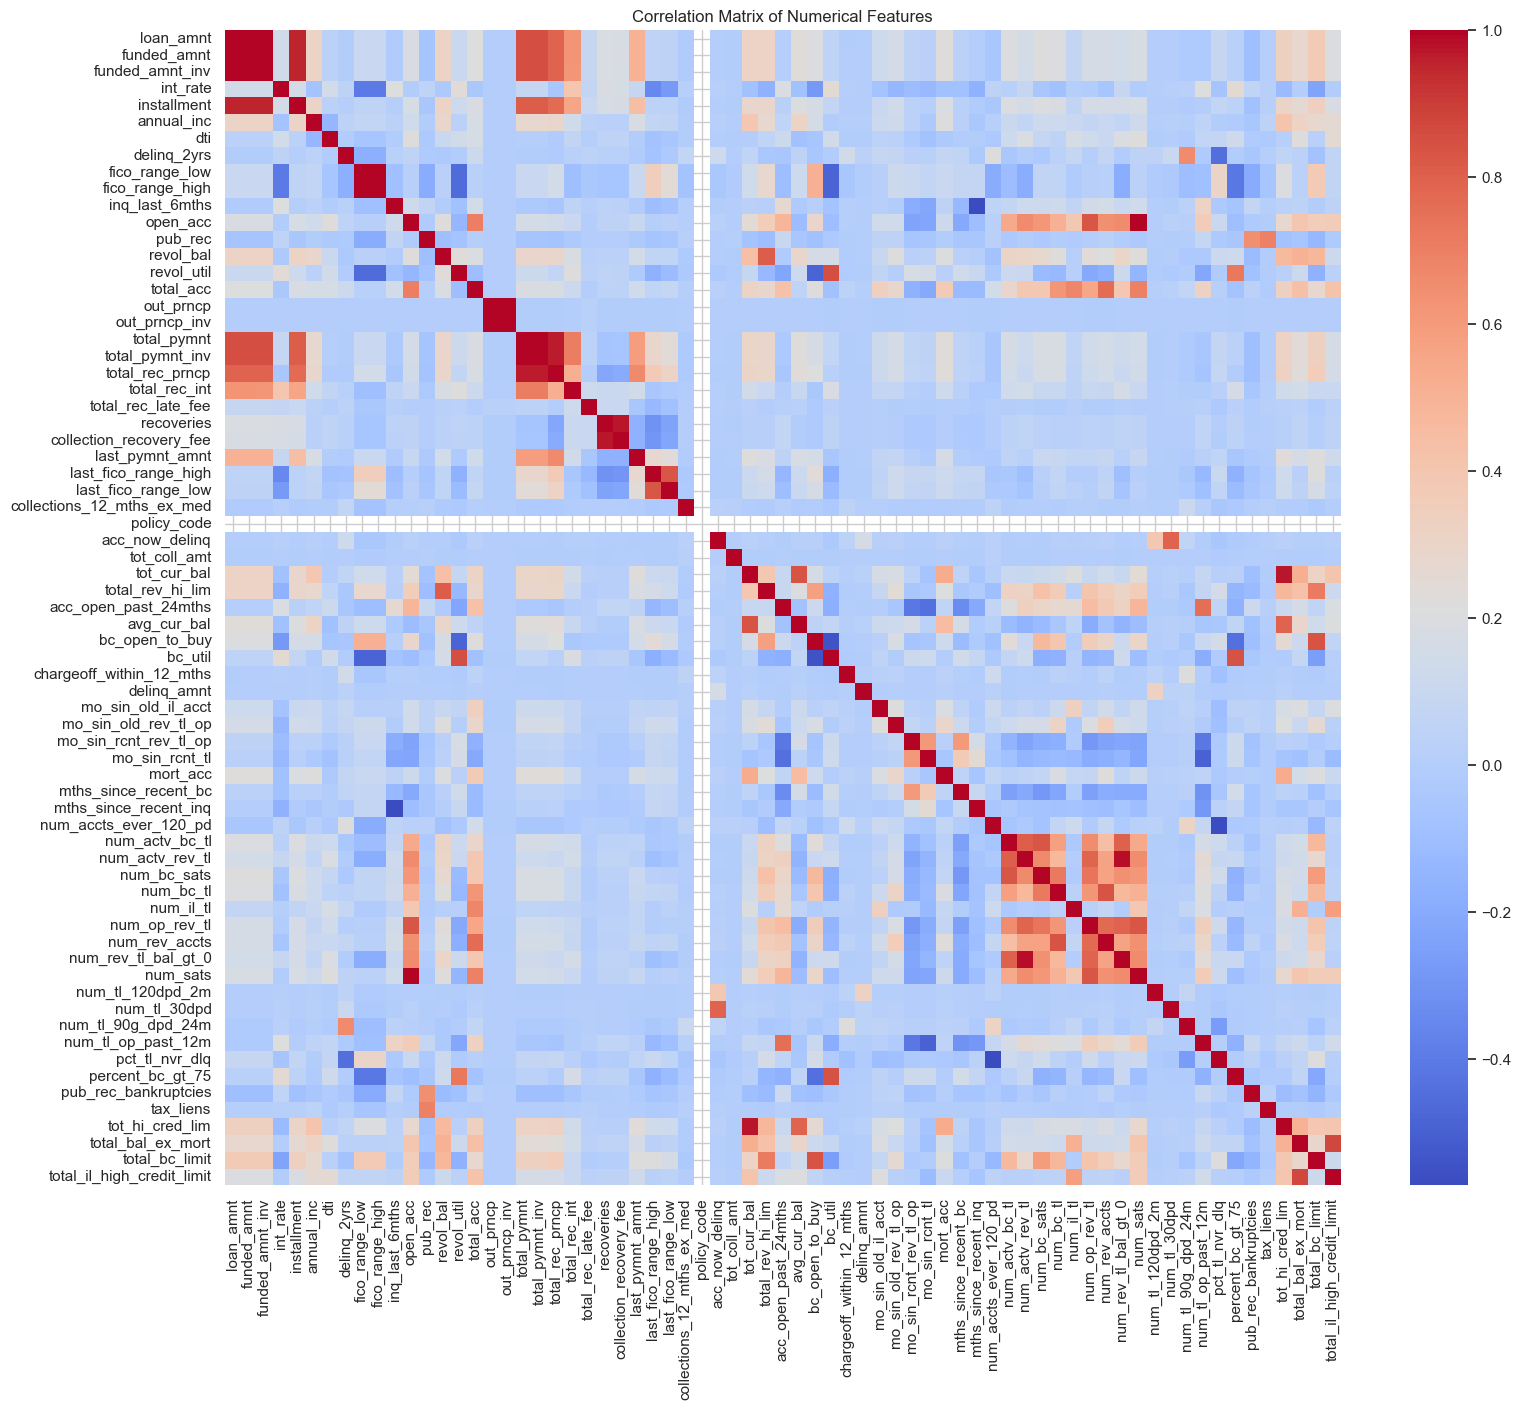


Pairs with absolute correlation > 0.85:
  - bc_util and revol_util: 0.855
  - collection_recovery_fee and recoveries: 0.970
  - fico_range_high and fico_range_low: 1.000
  - funded_amnt and funded_amnt_inv: 0.999
  - funded_amnt and installment: 0.954
  - funded_amnt and loan_amnt: 1.000
  - funded_amnt and total_pymnt: 0.855
  - funded_amnt and total_pymnt_inv: 0.854
  - funded_amnt_inv and installment: 0.953
  - funded_amnt_inv and loan_amnt: 0.998
  - funded_amnt_inv and total_pymnt: 0.854
  - funded_amnt_inv and total_pymnt_inv: 0.855
  - installment and loan_amnt: 0.953
  - loan_amnt and total_pymnt: 0.854
  - loan_amnt and total_pymnt_inv: 0.854
  - num_actv_rev_tl and num_rev_tl_bal_gt_0: 0.982
  - num_sats and open_acc: 0.999
  - out_prncp and out_prncp_inv: 1.000
  - tot_cur_bal and tot_hi_cred_lim: 0.973
  - total_bal_ex_mort and total_il_high_credit_limit: 0.873
  - total_pymnt and total_pymnt_inv: 0.999
  - total_pymnt and total_rec_prncp: 0.967
  - total_pymnt_inv and tot

In [ ]:
# %%

# Feature-feature correlation matrix
if df is not None and numerical_cols:
    print("\n--- Feature-Feature Correlation Matrix --- ")
    corr_matrix = df[numerical_cols].corr(numeric_only=True)
    plt.figure(figsize=(18, 15))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()

    # Identify highly correlated pairs
    threshold = 0.85
    highly_correlated_pairs = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                pair = tuple(sorted((corr_matrix.columns[i], corr_matrix.columns[j])))
                highly_correlated_pairs.add(pair)

    if highly_correlated_pairs:
        print(f"\nPairs with absolute correlation > {threshold}:")
        for pair in sorted(list(highly_correlated_pairs)):
            corr_value = corr_matrix.loc[pair[0], pair[1]]
            print(f"  - {pair[0]} and {pair[1]}: {corr_value:.3f}")
    else:
        print(f"\nNo pairs found with absolute correlation > {threshold}.")


 **Findings (Feature-Feature Correlation):**
 *   Heatmap reveals blocks of high correlation (loan amounts, FICO ranges, payment details, account counts).
 *   Explicit list confirms multicollinearity issues (e.g., `loan_amnt`/`installment`, `fico_range_low`/`high`, `num_sats`/`open_acc`).
 *   **Implication:** Feature selection required to address multicollinearity.


 #### 4.4 Selection Rationale and Final List for EDA Visualisation

In [ ]:
# %%

# Define key features for visual exploration
key_numerical_features_for_viz = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'delinq_2yrs'
]
key_categorical_features_for_viz = [
    'term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
    'verification_status', 'purpose'
]

# Verify lists against available columns
if df is not None:
    final_numerical_to_viz = [f for f in key_numerical_features_for_viz if f in df.columns]
    final_categorical_to_viz = [f for f in key_categorical_features_for_viz if f in df.columns]
    print("\n--- Final Features Selected for Visual Exploration ---")
    print(f"Numerical: {final_numerical_to_viz}")
    print(f"Categorical: {final_categorical_to_viz}")
else:
    final_numerical_to_viz, final_categorical_to_viz = [], []


--- Final Features Selected for Visual Exploration ---
Numerical: ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'delinq_2yrs']
Categorical: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose']



 **Findings:** Curated lists for focused visual analysis based on prior steps and domain knowledge.


 ### 5. Explore Key Selected Variables (Visualisations)


 #### 5.1 Numerical Features Exploration (Selected)


--- Univariate Distributions (Histograms) --- 


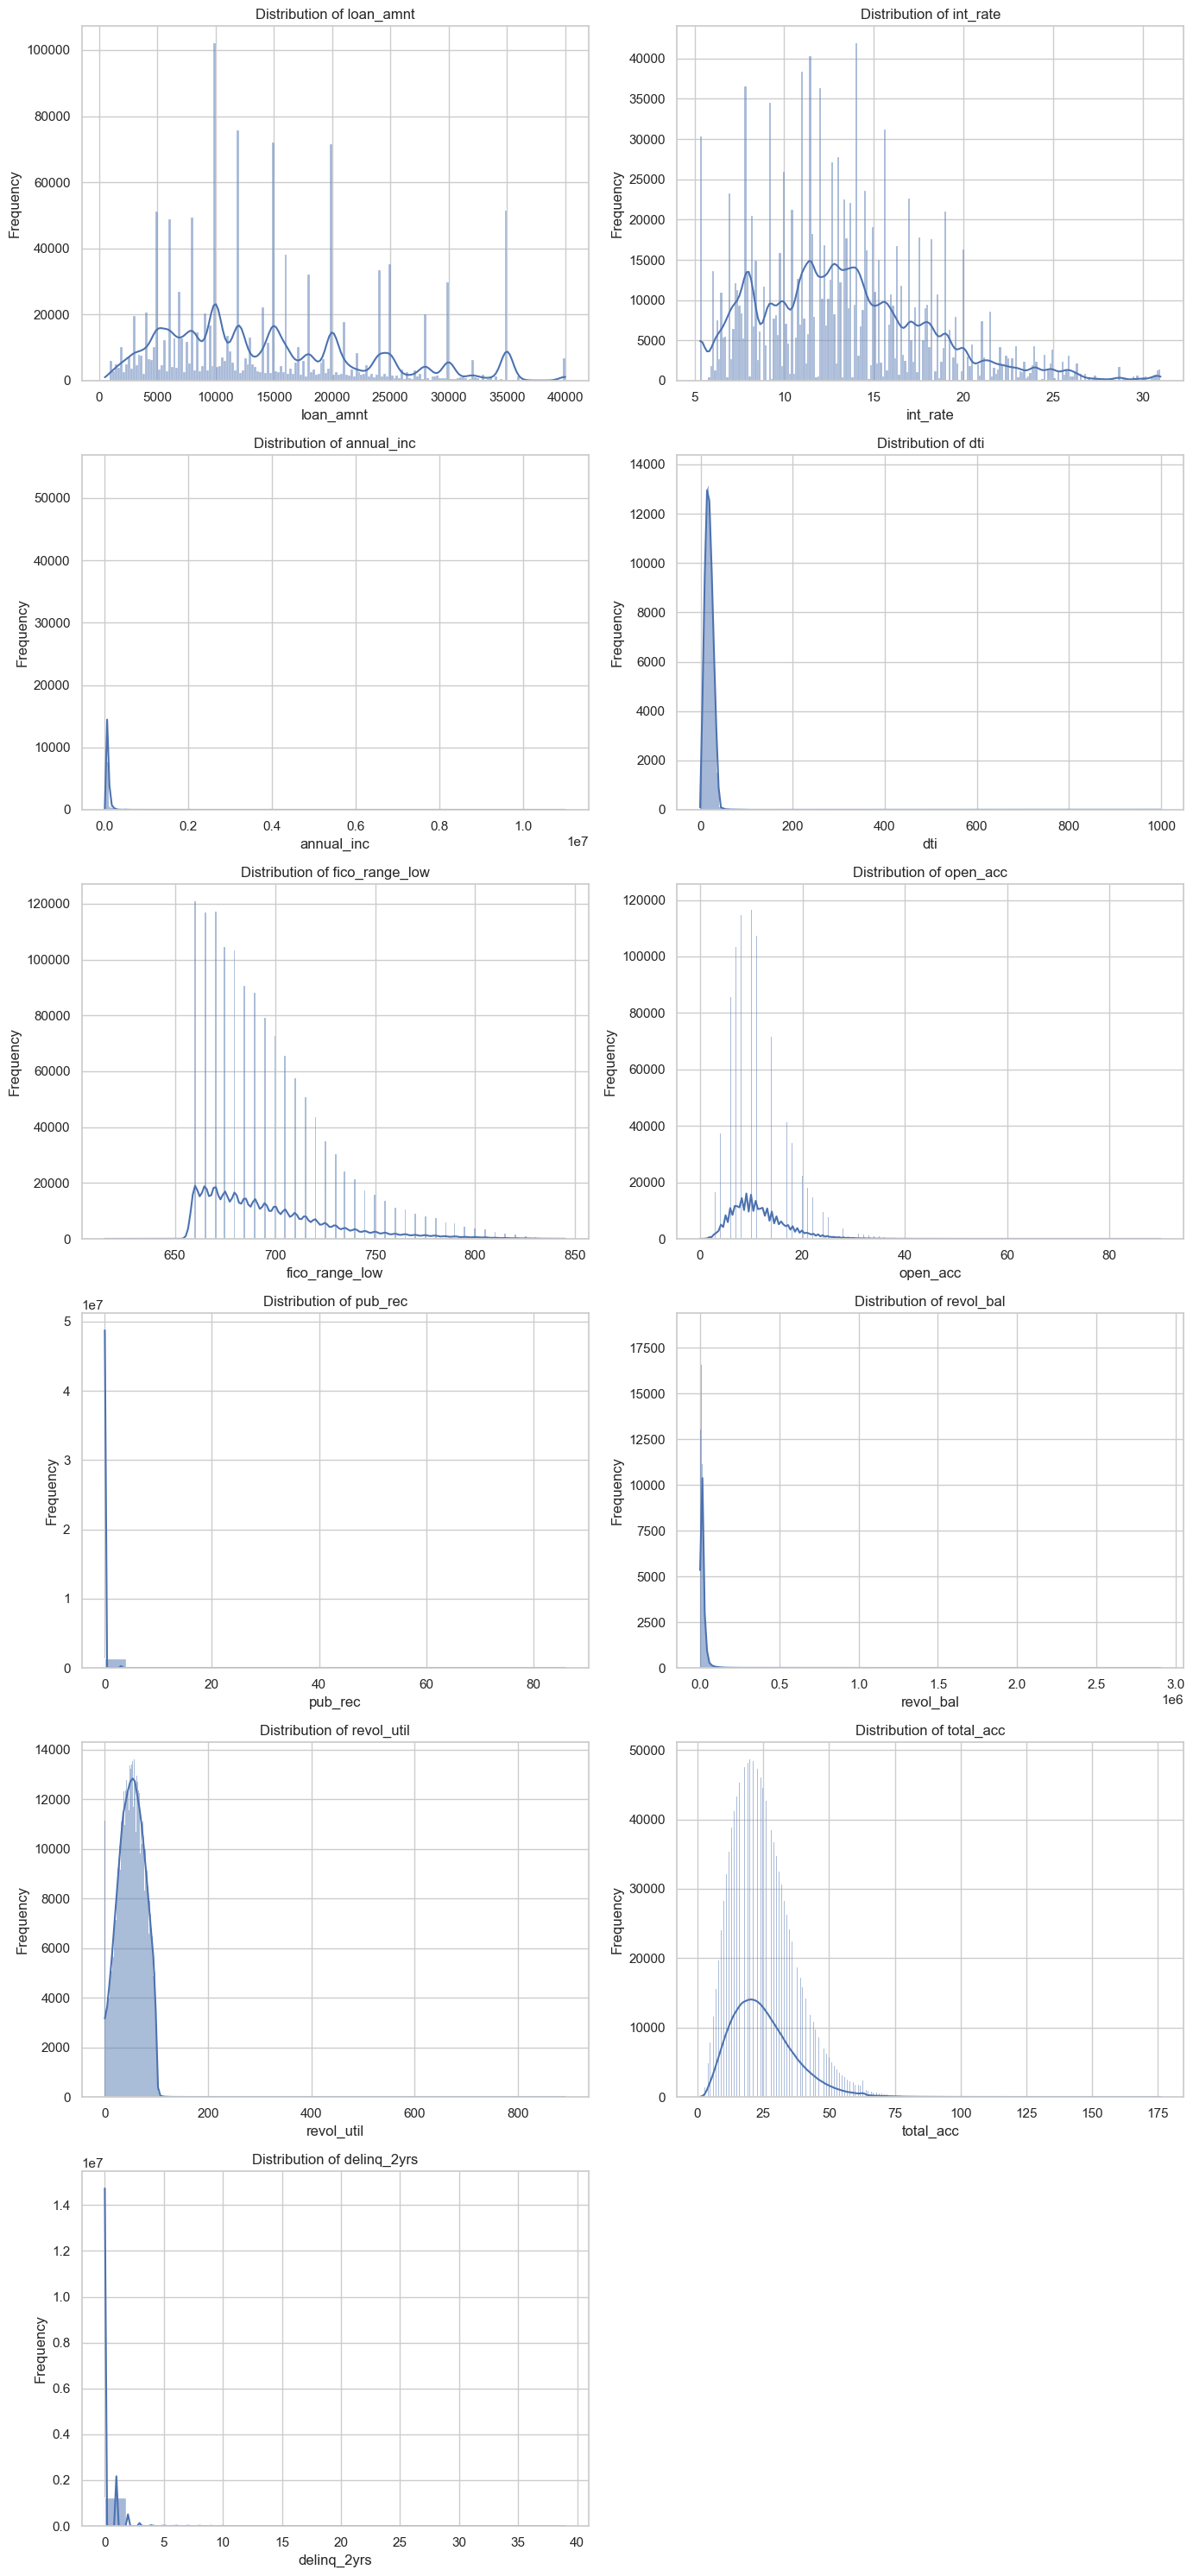

In [ ]:
# %%

# Plot histograms for selected numerical features
if df is not None and final_numerical_to_viz:
    print("\n--- Univariate Distributions (Histograms) --- ")
    n_cols = 2
    n_rows = (len(final_numerical_to_viz) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, n_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(final_numerical_to_viz):
        sns.histplot(data=df, x=col, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()


 **Findings (Histograms):**
 *   Confirms distribution shapes: `loan_amnt` (lumpy/skewed), `int_rate` (multimodal), `annual_inc`/`dti`/`revol_bal` (heavily right-skewed), `fico_range_low` (peaked/left-skewed), `pub_rec`/`delinq_2yrs` (zero-inflated).
 *   **Implication:** Reinforces need for transformations for skewed features.


--- Bivariate Distributions (Box Plots vs. is_bad) --- 


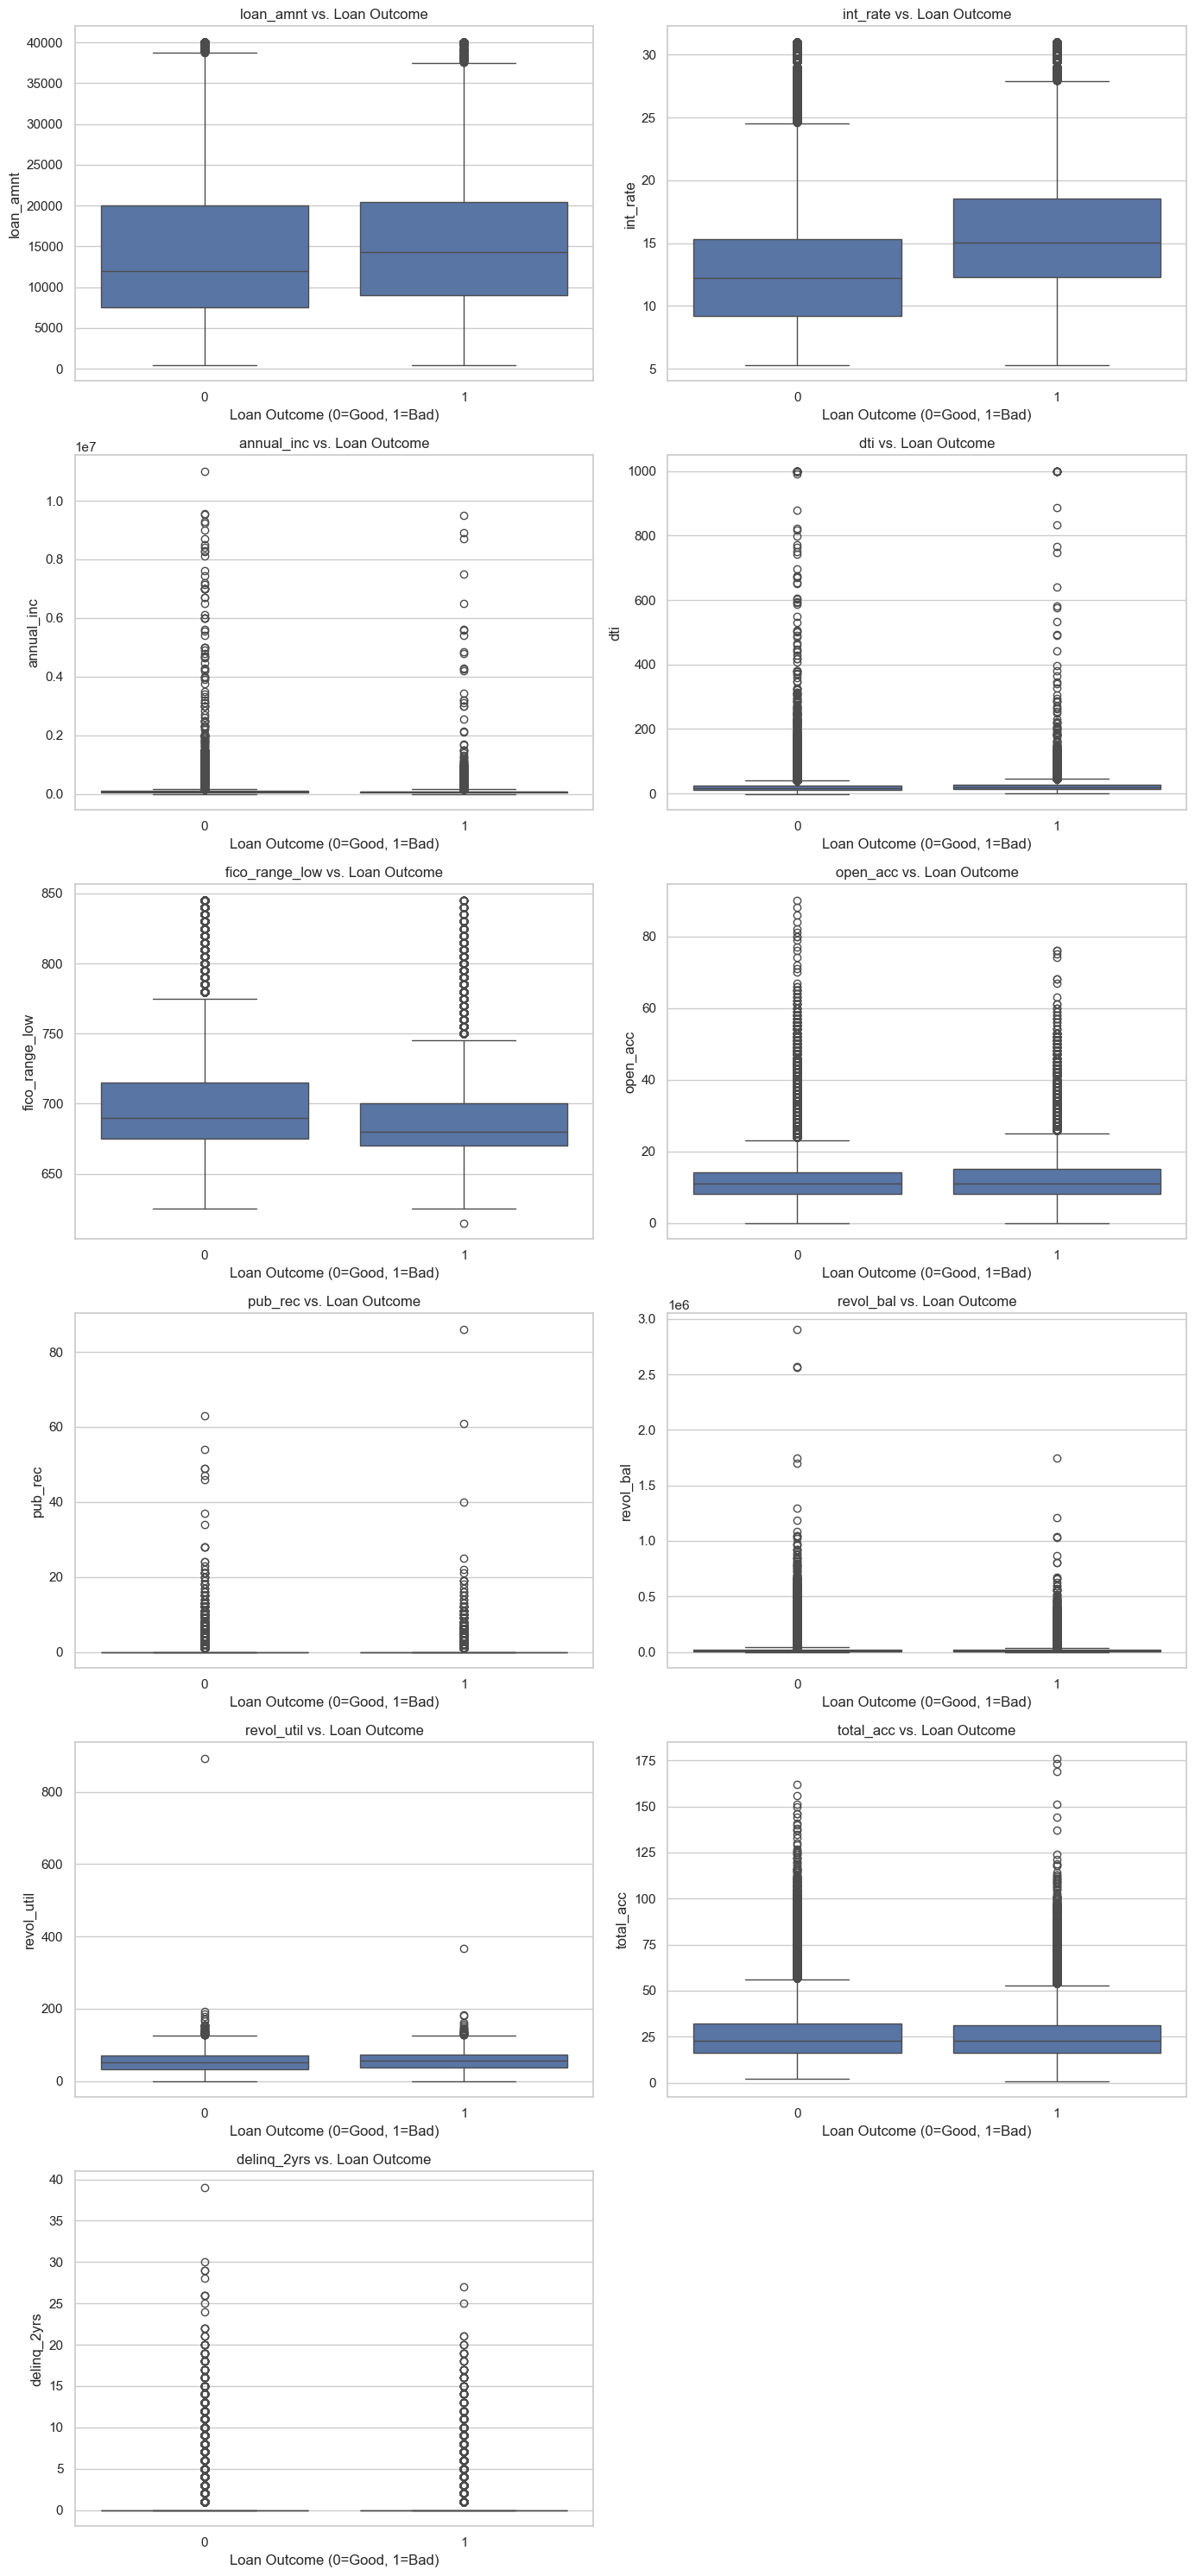

In [ ]:
# %%

# Plot box plots vs. target for selected numerical features
if df is not None and final_numerical_to_viz:
    print("\n--- Bivariate Distributions (Box Plots vs. is_bad) --- ")
    n_cols = 2
    n_rows = (len(final_numerical_to_viz) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, n_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(final_numerical_to_viz):
        sns.boxplot(x='is_bad', y=col, data=df, ax=axes[i])
        axes[i].set_title(f'{col} vs. Loan Outcome')
        axes[i].set_xlabel('Loan Outcome (0=Good, 1=Bad)')
        axes[i].set_ylabel(col)

    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()


 **Findings (Box Plots vs. Target):**
 *   **Clear Separation:** `int_rate`, `fico_range_low`.
 *   **Noticeable Shift:** `dti`, `revol_util`, `open_acc`, `delinq_2yrs`.
 *   **Less Clear / Outlier Effects:** `loan_amnt`, `annual_inc`, `revol_bal`.
 *   **Implication:** Supports predictive potential of `int_rate`, `fico_range_low`, `dti`, `revol_util`, `open_acc`, `delinq_2yrs`. Features with outliers need careful handling.


 ##### Visualizing Skew Transformation Effect (Example)


--- Visualizing Effect of Yeo-Johnson Transformation --- 


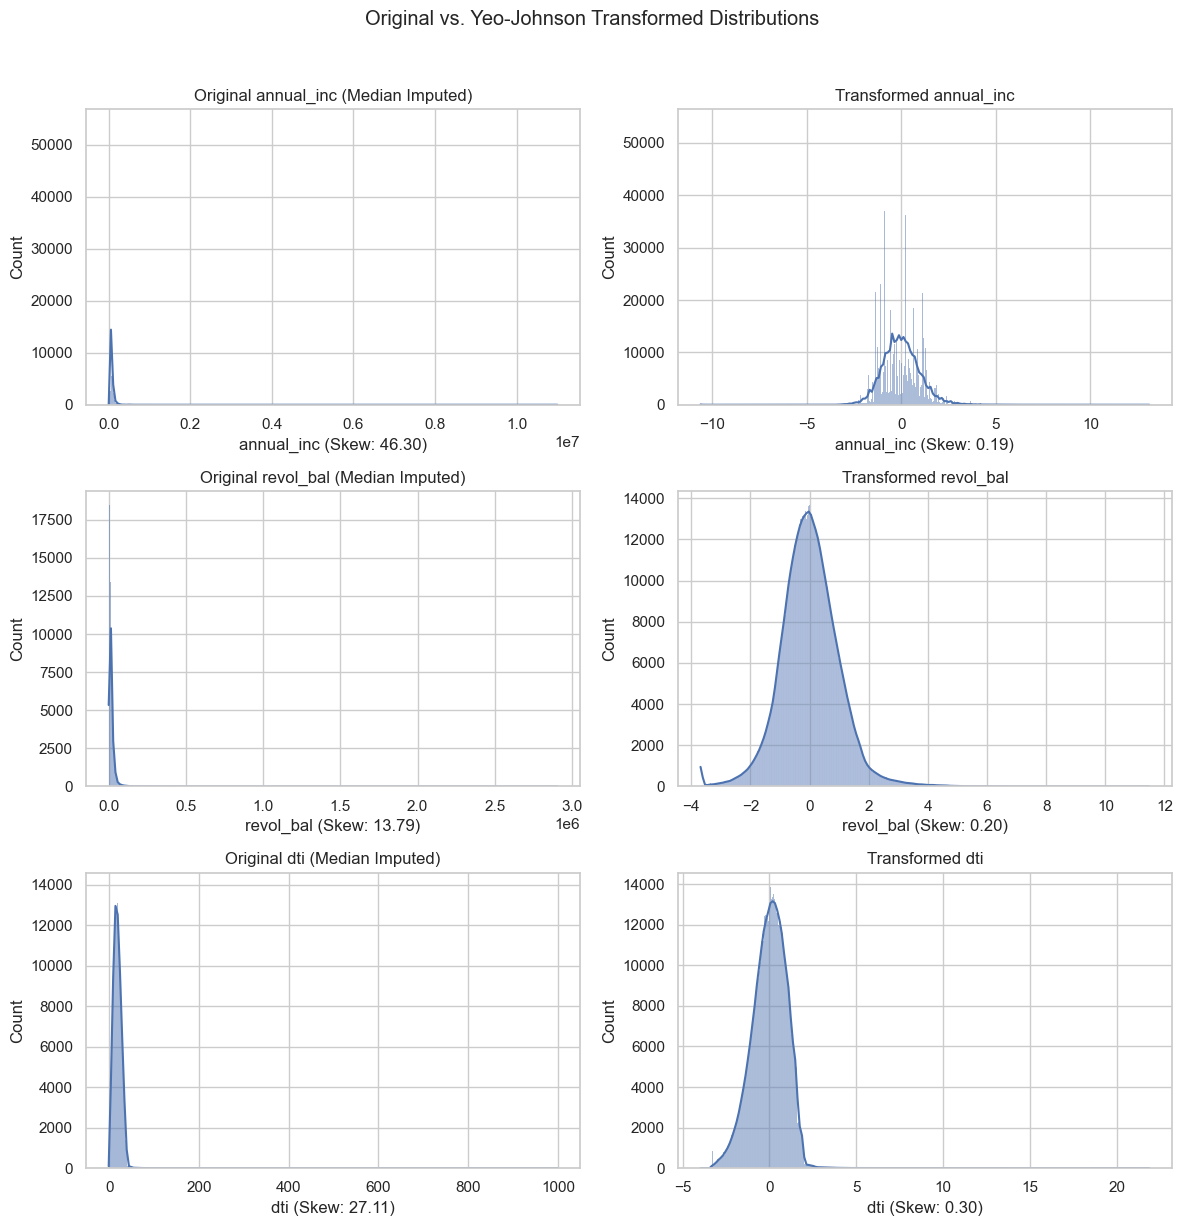

In [ ]:
# %%

# Demonstrate Yeo-Johnson Transformation effect
if df is not None and 'annual_inc' in df.columns and 'revol_bal' in df.columns and 'dti' in df.columns:
    from sklearn.preprocessing import PowerTransformer
    from sklearn.impute import SimpleImputer
    import matplotlib.pyplot as plt
    import seaborn as sns

    print("\n--- Visualizing Effect of Yeo-Johnson Transformation --- ")
    skewed_demo_cols = ['annual_inc', 'revol_bal', 'dti']
    df_demo = df[skewed_demo_cols].copy()

    # Impute missing values for visualization consistency
    imputer = SimpleImputer(strategy='median')
    df_demo_imputed = pd.DataFrame(imputer.fit_transform(df_demo), columns=skewed_demo_cols)

    # Apply Yeo-Johnson transformation
    pt = PowerTransformer(method='yeo-johnson')
    df_transformed = pd.DataFrame(pt.fit_transform(df_demo_imputed), columns=skewed_demo_cols)

    # Plot original vs transformed distributions
    fig, axes = plt.subplots(len(skewed_demo_cols), 2, figsize=(12, len(skewed_demo_cols) * 4))
    fig.suptitle('Original vs. Yeo-Johnson Transformed Distributions', y=1.02)

    for i, col in enumerate(skewed_demo_cols):
        # Original (imputed)
        skew_orig = df_demo_imputed[col].skew()
        sns.histplot(df_demo_imputed[col], kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Original {col} (Median Imputed)')
        axes[i, 0].set_xlabel(f'{col} (Skew: {skew_orig:.2f})')

        # Transformed
        skew_transformed = pd.Series(df_transformed[col]).skew()
        sns.histplot(df_transformed[col], kde=True, ax=axes[i, 1])
        axes[i, 1].set_title(f'Transformed {col}')
        axes[i, 1].set_xlabel(f'{col} (Skew: {skew_transformed:.2f})')

    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping transformation visualization: DataFrame or key columns not available.")


 Applying Yeo-Johnson transformation significantly reduces skewness in example features (`annual_inc`, `revol_bal`, `dti`), supporting its inclusion in the preprocessing pipeline.


 #### 5.2 Categorical Features Exploration (Selected)



 ##### Univariate Distributions (Counts)


--- Univariate Distributions (Count Plots) --- 


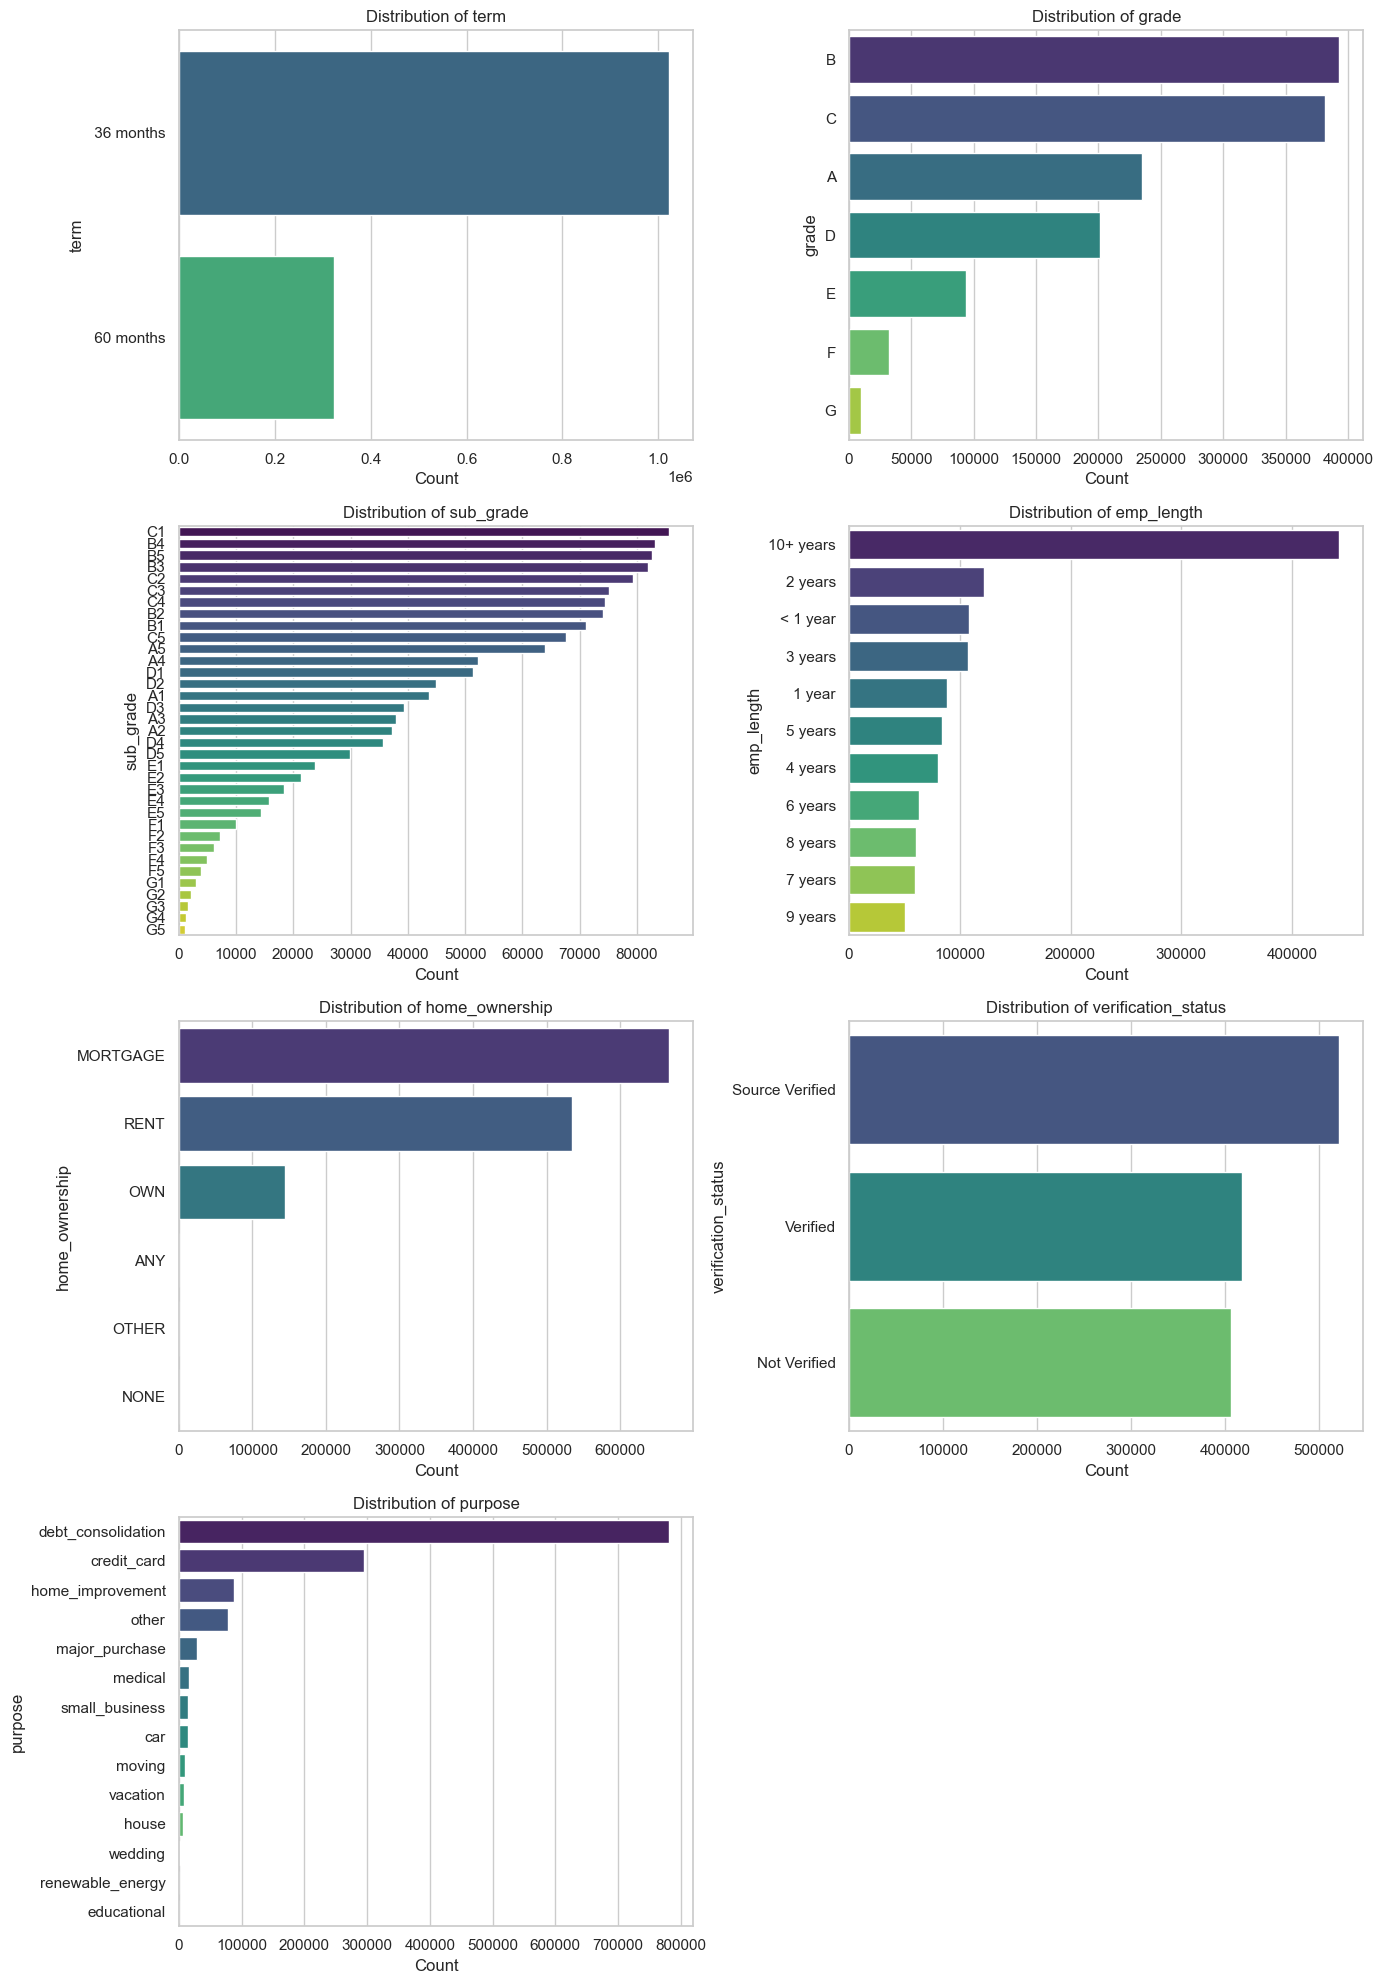

In [ ]:
# %%

# Plot count plots for selected categorical features
if df is not None and final_categorical_to_viz:
    print("\n--- Univariate Distributions (Count Plots) --- ")
    n_cols = 2
    n_rows = (len(final_categorical_to_viz) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, n_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(final_categorical_to_viz):
        order = df[col].value_counts().index
        sns.countplot(data=df, y=col, ax=axes[i], order=order, palette='viridis')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel(col)

    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()
else:
    print("\nDataFrame not available or no categorical features to plot.")



 *   Highlights dominant categories (`term`='36 months', `grade`=B/C, `emp_length`='10+ years', `home_ownership`='MORTGAGE', `purpose`='debt_consolidation').
 *   **Implication:** Potential need for handling rare categories during encoding.


 ##### Bivariate Analysis (Bad Rate per Category)


--- Bivariate Analysis (Bad Rate per Category) --- 


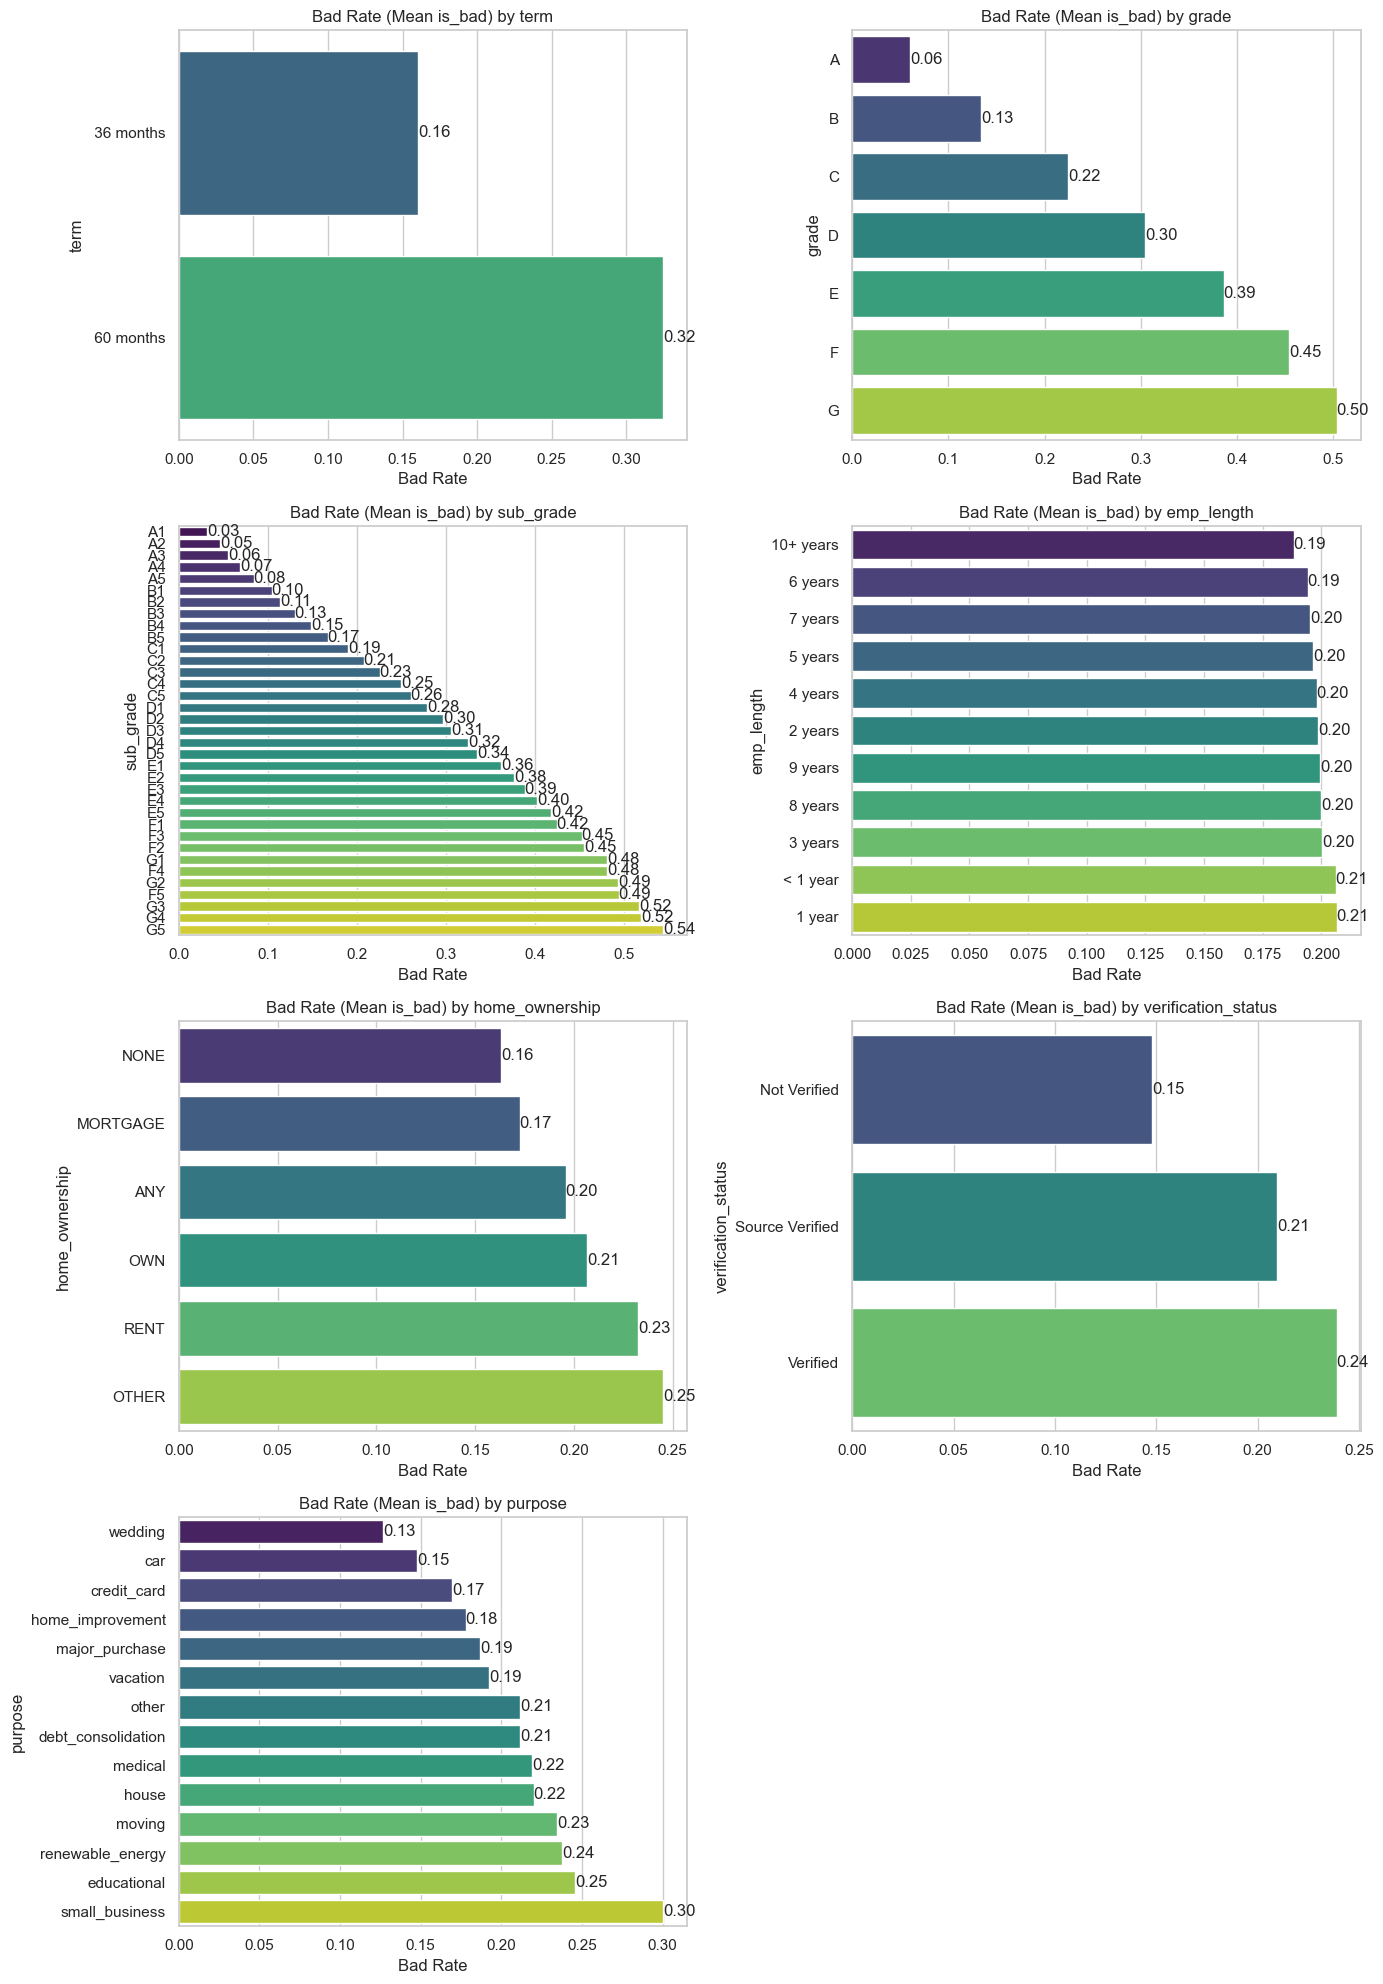

In [ ]:
# %%

# Plot bad rates for selected categorical features
if df is not None and final_categorical_to_viz:
    print("\n--- Bivariate Analysis (Bad Rate per Category) --- ")
    n_cols = 2
    n_rows = (len(final_categorical_to_viz) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, n_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(final_categorical_to_viz):
        bad_rate = df.groupby(col, observed=False)['is_bad'].mean().sort_values()
        sns.barplot(x=bad_rate.values, y=bad_rate.index.astype(str), ax=axes[i], palette='viridis')
        axes[i].set_title(f'Bad Rate (Mean is_bad) by {col}')
        axes[i].set_xlabel('Bad Rate')
        axes[i].set_ylabel(col)
        for container in axes[i].containers:
            axes[i].bar_label(container, fmt='%.2f')

    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()
else:
    print("\nDataFrame not available or no categorical features to plot.")


 **Findings (Bad Rate per Category):**
 *   `term`: '60 months' (~0.31) nearly double the bad rate of '36 months' (~0.17).
 *   `grade`/`sub_grade`: Strong monotonic increase in bad rate (A ~0.07 to G ~0.50).
 *   `emp_length`: Non-linear; '< 1 year' highest rate (~0.25).
 *   `home_ownership`: 'RENT' (~0.25) higher than 'MORTGAGE' (~0.20).
 *   `verification_status`: Counter-intuitive; 'Verified' (~0.24) highest rate.
 *   `purpose`: 'small_business' highest rate (~0.34).
 *   **Implication:** `grade`, `term`, `purpose`, `home_ownership` show significant discriminatory power. Requires appropriate encoding.


 ### 6. Assess Historical Policy Impact (Trends Over Time)


 #### 6.1 Prepare Data for Time Series Analysis

In [ ]:
# %%

# Extract year and month from issue_d
if df is not None and 'issue_d' in df.columns and pd.api.types.is_datetime64_any_dtype(df['issue_d']):
    df['issue_year'] = df['issue_d'].dt.year
    df['issue_month_yr'] = df['issue_d'].dt.to_period('M')
    print(f"\nTime features created. Year range: {df['issue_year'].min()} - {df['issue_year'].max()}")
else:
    print("\nDataFrame not available or issue_d not parsed.")


Time features created. Year range: 2007 - 2018



 #### 6.2 Analyse Trends by Year


--- Yearly Trend Analysis --- 
Yearly Aggregated Statistics:

    issue_year  loan_count  avg_loan_amnt  avg_int_rate  avg_fico_low  \
0         2007         364    9019.505495     11.349478    699.958791   
1         2008        1811    9185.601877     11.521010    704.580342   
2         2009        4845    9867.476780     12.263020    716.505676   
3         2010       11806   10561.676266     11.835981    714.222006   
4         2011       21721   12047.503568     12.223365    714.991713   
5         2012       53367   13461.709015     13.637787    701.387093   
6         2013      134804   14707.375152     14.531628    694.998887   
7         2014      223103   14582.903412     13.656289    692.467874   
8         2015      375546   14641.618204     12.385206    693.517425   
9         2016      293105   14467.039457     13.086688    695.300780   
10        2017      169321   14301.253093     13.918352    699.337176   
11        2018       56318   14881.155670     13.430023    70

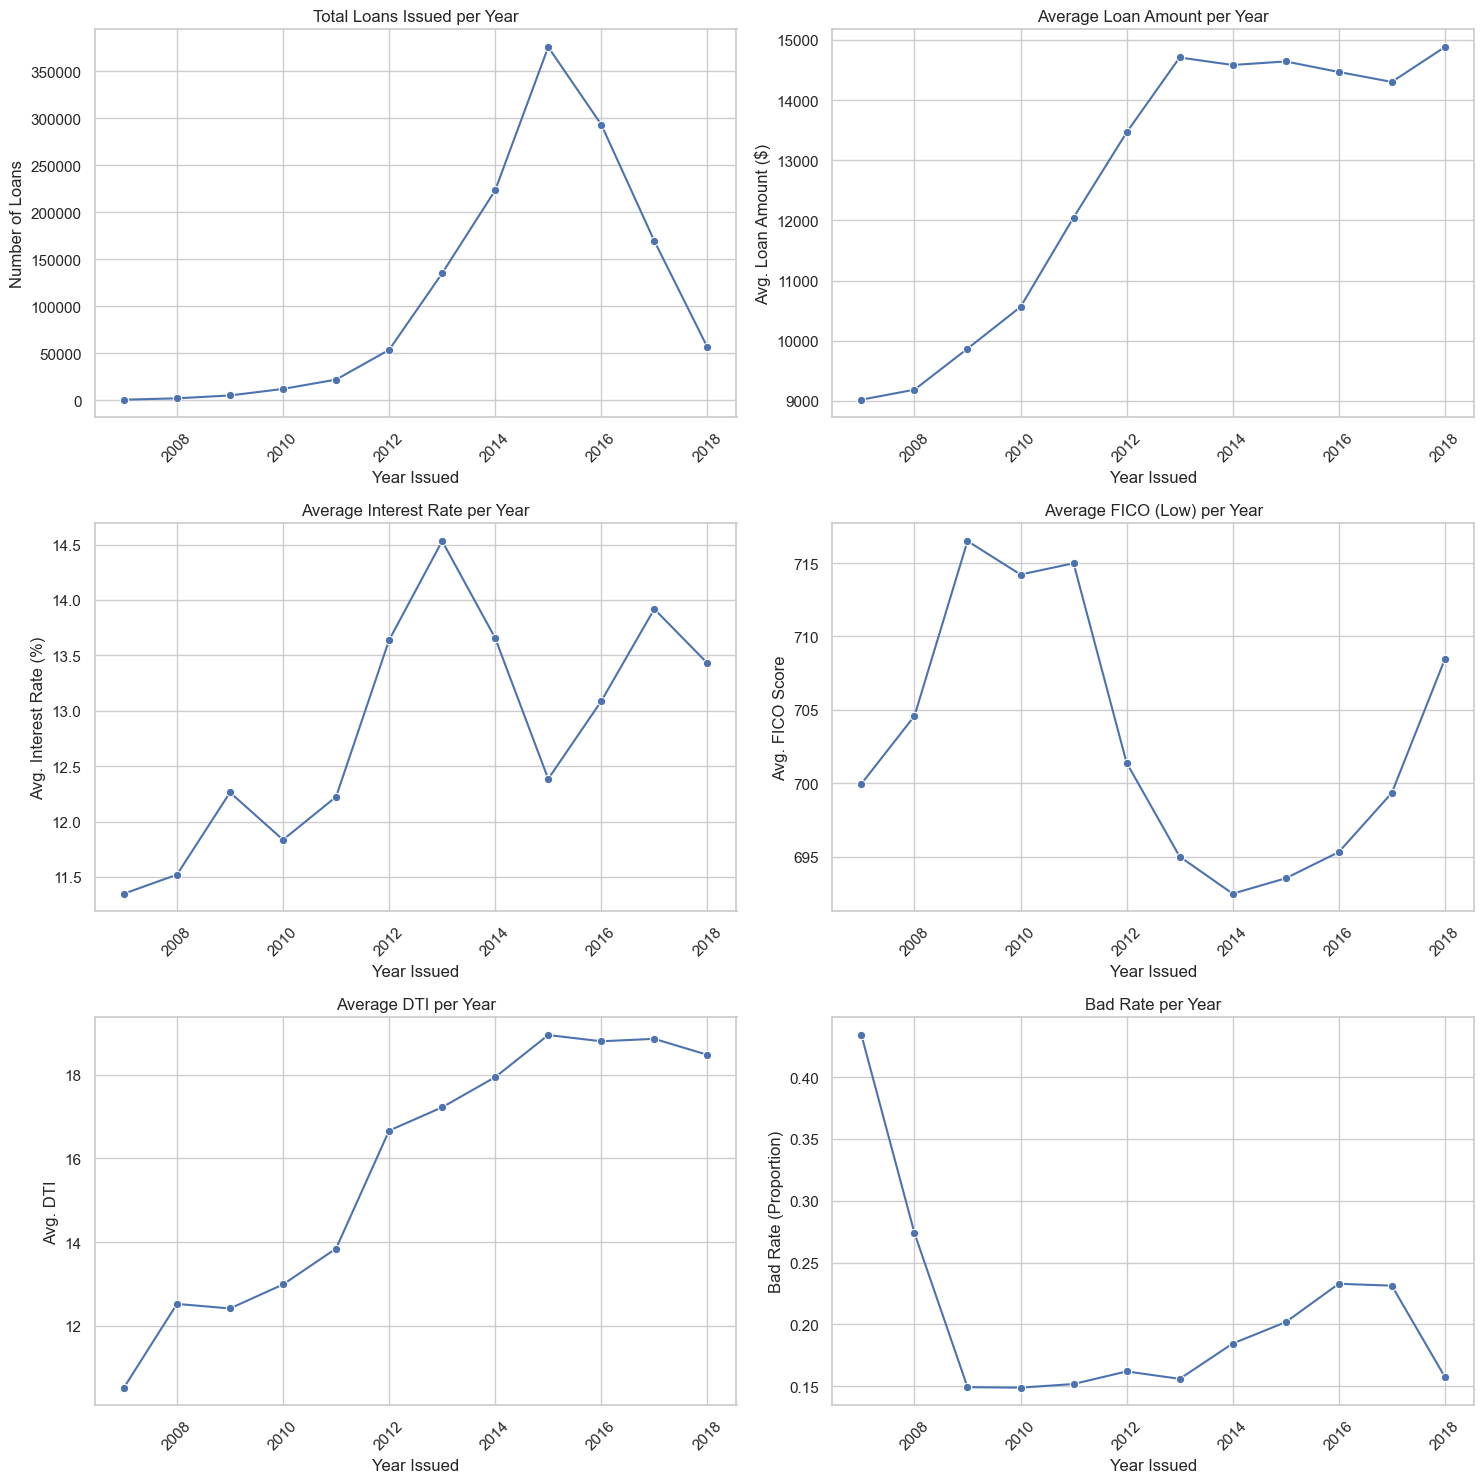

In [ ]:
# %%

# Analyse yearly trends
if df is not None and 'issue_year' in df.columns:
    print("\n--- Yearly Trend Analysis --- ")
    yearly_stats = df.groupby('issue_year').agg(
        loan_count=('id', 'count'),
        avg_loan_amnt=('loan_amnt', 'mean'),
        avg_int_rate=('int_rate', 'mean'),
        avg_fico_low=('fico_range_low', 'mean'),
        avg_dti=('dti', 'mean'),
        bad_rate=('is_bad', 'mean')
    ).reset_index()

    print("Yearly Aggregated Statistics:\n")
    print(yearly_stats)

    # Plot trends
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    axes = axes.flatten()
    plot_metrics = {
        'loan_count': ('Total Loans Issued per Year', 'Number of Loans'),
        'avg_loan_amnt': ('Average Loan Amount per Year', 'Avg. Loan Amount ($)'),
        'avg_int_rate': ('Average Interest Rate per Year', 'Avg. Interest Rate (%)'),
        'avg_fico_low': ('Average FICO (Low) per Year', 'Avg. FICO Score'),
        'avg_dti': ('Average DTI per Year', 'Avg. DTI'),
        'bad_rate': ('Bad Rate per Year', 'Bad Rate (Proportion)')
    }
    metric_keys = list(plot_metrics.keys())

    for i, metric in enumerate(metric_keys):
        title, ylabel = plot_metrics[metric]
        sns.lineplot(data=yearly_stats, x='issue_year', y=metric, ax=axes[i], marker='o')
        axes[i].set_title(title)
        axes[i].set_ylabel(ylabel)
        axes[i].set_xlabel('Year Issued')
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

else:
    print("\nDataFrame not available or time columns not created.")


 **Findings (Yearly Trends):**
 *   **Loan Count:** Exponential growth until 2015 peak, then decrease.
 *   **Avg Loan Amount:** Consistent upward trend.
 *   **Avg Interest Rate:** Fluctuated, peaked ~2013.
 *   **Avg FICO (Low):** Volatile; dipped 2011-2014.
 *   **Avg DTI:** Steady significant increase.
 *   **Bad Rate:** Started high (>0.40 2007), dropped sharply (~0.15 2009-2011), climbed steadily >0.25 by 2017-2018.
 *   **Implications:** Portfolio composition and risk changed dramatically. Mandates time-aware validation and monitoring.


 ### 7. Summary of EDA Findings



 **Key Findings & Implications for Modelling:**
 *   **Target Variable:** Binary `is_bad` defined ('Charged Off', 'Default' vs. 'Fully Paid'). Class imbalance noted (~20% bad rate - needs recalculation).
 *   **Data Quality & Cleaning:** High-missing columns dropped (>40%). Remaining missing values require imputation. Near-zero variance column (`policy_code`) identified. Dates parsed.
 *   **Feature Importance (Initial Assessment):** Strong predictors (`int_rate`, `grade`, `term`, `fico_range_low`, etc.). Skewed features need transformation (`dti`, `annual_inc`). Multicollinearity requires selection. Leakage variables identified.
 *   **Historical Trends & Concept Drift:** Significant changes over time confirmed. Mandates time-aware validation & monitoring.
 *   **Preprocessing Needs Summary:** Modelling requires: imputation, skewness transformation, categorical encoding, scaling, feature selection (multicollinearity, leakage).